# Financial Discourse: Trump's Tweets and Stock Market Dynamics
##### Author: Wesley Barnes
* [Data Processing](#Data-Processing)
* [Tweet Sentiment Analysis](#Tweet-Sentiment-Analysis)
* [Combining Tweet & Stock Data](#Combining-Tweet-&-Stock-Data)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Regression Modeling](#Regression-Modeling)
* [Conclusion](#Conclusion)

This Jupyter Notebook explores the potential correlation between S&P 500 stock price trends and the average sentiment expressed in Donald Trump's tweets day to day. The S&P 500 is comprised of 500 of the largest companies, leading some investors to believe it provides a more accurate picture of the economy. By performing sentiment analysis on his tweets and analyzing the resulting sentiment scores, we aim to investigate whether there is a relationship between the sentiment of his tweets and the subsequent movement of S&P 500 stock prices. The notebook covers data preprocessing, sentiment analysis, feature engineering, and predictive modeling to determine if sentiment in Donald Trump's tweets can be utilized as a predictive factor for stock price changes.

In [1361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from scipy.stats import linregress
%matplotlib inline
import seaborn as sns
plt.style.use('default')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.optimize import curve_fit
import datetime
import warnings
warnings.filterwarnings("ignore")

# Initializing VADER Sentiment Analysis Tool for Textual Data
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Modeling Packages
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from itertools import combinations


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/wesleybarnes/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Processing <a class="anchor" id="Data-Processing"></a>


In [1289]:
# Load the tweet dataset
tweets = pd.read_csv('trump_tweets.csv')


# Initializing start and end dates
start_date = '2016-05-03'
end_date = tweets['created_at'].max()


# Subsetting data to only be between the start/end dates, and to not include retweets
tweets1 = tweets[(tweets['created_at'] >= start_date) & 
                 (tweets['created_at'] <= end_date) & 
                 (~tweets['text'].str.contains('RT'))]


# Simplify 'created_at' column
tweets1.created_at = tweets.created_at.str[0:10]


# Rename 'created_at' column to 'date'
tweets2 = tweets1.rename(columns={'created_at':'date'})


# Add a new column totalling 'retweet_count' and 'favorite_count'ArithmeticError
tweets2['total_engagement'] = tweets2.retweet_count + tweets2.favorite_count


# Selecting necessary columns
tweets3 = tweets2.loc[:,['text','date','retweet_count','favorite_count', 'total_engagement']]

In [1290]:
# Load the stock dataset
stocks = pd.read_csv('all_stocks_5yr.csv')


# Creating a column to represent the percent change of a stock
stocks['percent_change'] = ((stocks['close'] - stocks['open']) / stocks['open']) * 100


# Comprehensive dataset of all stocks in the s&p by 'date'
stocks_df = stocks.loc[:,['date','volume', 'percent_change', 'Name']]


# Comprehensive dataset of the average 'percent_change' and total volume of all stocks in the s&p
stocks_df2 = stocks_df.groupby(['date']).agg({
    'percent_change': 'mean',
    'volume': 'sum'
}).reset_index()

## Tweet Sentiment Analysis <a class="anchor" id="Tweet-Sentiment-Analysis"></a>


In [1291]:
# Add a new column to the DataFrame for sentiment scores
tweets3.loc[:,'sentiment'] = tweets3['text'].apply(lambda x: sid.polarity_scores(x)['compound'])


# Calculate the mean of 'rewteet_count', 'favorite_count', and 'sentiment' by 'date'
tweets_df = tweets3.groupby(['date'])['retweet_count', 'favorite_count', 'sentiment', 'total_engagement'].mean()


# Classify sentiment based on the 'sentiment' score
tweets_df.loc[:,'sentiment_label'] = tweets_df['sentiment'].apply(lambda x: 'positive' if x > 0 
                                                    else ('negative' if x < 0 else 'neutral'))

## Combining Tweet & Stock Data <a class="anchor" id="Combining-Tweet-&-Stock-Data"></a>

In [1292]:
# dataframe by each stock
df = pd.merge(tweets_df,stocks_df, on='date', how='inner')


# dataframe by all stocks
df2 = pd.merge(tweets_df, stocks_df2, on='date', how='inner')


# Drop NA rows
df = df.dropna()


# Drop NA rows
df2 = df2.dropna()


# Correct column order
df = df[['date','retweet_count','favorite_count', 'total_engagement', 'sentiment','sentiment_label', 'volume', 'percent_change','Name']]
df2 = df2[['date','retweet_count','favorite_count', 'total_engagement','sentiment','sentiment_label','volume', 'percent_change']]


# Convert the 'date' column to a datetime format (df)
df['date'] = pd.to_datetime(df['date'])


# Set 'date' column as the index (df)
df.set_index('date', inplace=True)


# Convert the 'date' column to a datetime format (df2)
df2['date'] = pd.to_datetime(df2['date'])


# Set 'date' column as the index (df2)
df2.set_index('date', inplace=True)

df2['change'] = np.where(df2.percent_change > 0, 'positive', 'negative')

## Exploratory Data Analysis <a class="anchor" id="Exploratory-Data-Analysis"></a>
In this exploratory data analysis (EDA), we delve into the intriguing relationship between Donald Trump's tweets and the movement of the S&P 500 index. By analyzing the sentiment and content of his tweets alongside fluctuations in the stock market, we aim to uncover potential correlations and insights that shed light on the impact of his public statements on financial markets. Through visualizations and data exploration, we seek to understand the dynamic interplay between social media discourse and stock market trends during this significant period.

### Types of Features <a class="anchor" id="Types-of-Features"></a>
#### Categorical Features:
- `sentiment_label`
#### Numerical Features:
- `retweet_count`
- `favorite_count`
- `total_engagement`
- `sentiment`
- `volume`
- `percent_change`

In [1293]:
# First five rows of Dataframe
df2.head(5)

,retweet_count,favorite_count,total_engagement,sentiment,sentiment_label,volume,percent_change,change
date,,,,,,,,
2016-05-03,6128.727273,18337.272727,24466.000000,0.567827,positive,2335733781,-0.257030,negative
2016-05-04,4891.714286,15691.000000,20582.714286,0.479157,positive,2234793847,-0.083262,negative
2016-05-05,21347.200000,36660.400000,58007.600000,0.010560,positive,2139971892,-0.214284,negative
2016-05-06,6888.666667,20319.333333,27208.000000,0.180073,positive,2054969905,0.744057,positive
2016-05-09,3401.842105,10503.894737,13905.736842,0.144847,positive,1844493929,0.105128,positive


In [1294]:
# Last five rows of Dataframe
df2.tail(5)

,retweet_count,favorite_count,total_engagement,sentiment,sentiment_label,volume,percent_change,change
date,,,,,,,,
2018-02-01,31922.333333,148801.000000,180723.333333,0.330333,positive,2491742144,0.116953,positive
2018-02-02,30232.333333,113718.000000,143950.333333,0.620167,positive,2751594961,-1.370027,negative
2018-02-05,31620.142857,135209.285714,166829.428571,0.034386,positive,3598437288,-3.026027,negative
2018-02-06,24961.800000,101265.200000,126227.000000,-0.122400,negative,4072080890,3.057519,positive
2018-02-07,23829.500000,110674.666667,134504.166667,0.757667,positive,2865639412,-0.044508,negative


In [1295]:
# Shape of Dataframe
df2.shape

(435, 8)

In [1296]:
# Checking datatypes
df2.dtypes

retweet_count       float64
favorite_count      float64
total_engagement    float64
sentiment           float64
sentiment_label      object
volume                int64
percent_change      float64
change               object
dtype: object

In [1297]:
# Checking for duplicated rows
df2.loc[df2.duplicated()]

,retweet_count,favorite_count,total_engagement,sentiment,sentiment_label,volume,percent_change,change
date,,,,,,,,


### Feature Understanding <a class="anchor" id="Feature-Understanding"></a>

In [1298]:
# Summary of the Dataframe
df2.describe()

,retweet_count,favorite_count,total_engagement,sentiment,volume,percent_change
count,435.000000,435.000000,435.000000,435.000000,4.350000e+02,435.000000
mean,16727.524674,67664.219303,84391.743977,0.228434,2.066676e+09,0.025598
std,9863.754977,40024.971251,49231.832757,0.295006,4.136923e+08,0.501792
min,2531.363636,8821.500000,11352.863636,-0.927200,7.282611e+08,-3.026027
25%,11026.928571,32628.482143,43975.363636,0.019107,1.841781e+09,-0.220147
50%,15343.090909,68701.500000,83716.000000,0.238633,2.015969e+09,0.036711
75%,21215.200000,89953.750000,110959.250000,0.435538,2.208225e+09,0.292285
max,133065.500000,412091.500000,545157.000000,0.977400,4.367393e+09,3.057519


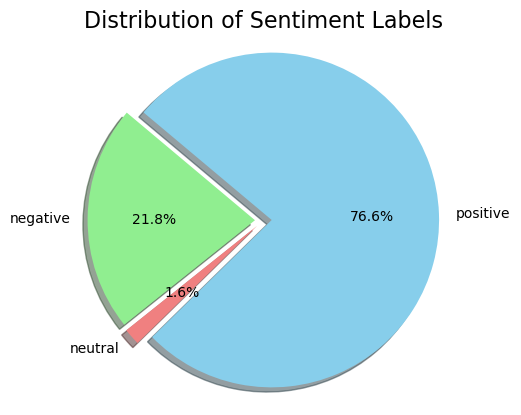

In [1299]:
# Group the data by 'sentiment_label' and count occurrences
sentiment_counts = df2.groupby('sentiment_label')['sentiment_label'].count()


# Create a white background
plt.figure(facecolor='white')


# Define colors for the pie chart slices
colors = ['lightgreen', 'lightcoral', 'skyblue']


# Plot a pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%',
        startangle=140, shadow=True, explode=(0.05, 0.05, 0.05))  # Added shadow and explode


plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.


# Add a title with a bigger font size
plt.title('Distribution of Sentiment Labels', fontsize=16)


plt.show()


### Feature Relationships <a class="anchor" id="Feature-Relationships"></a>

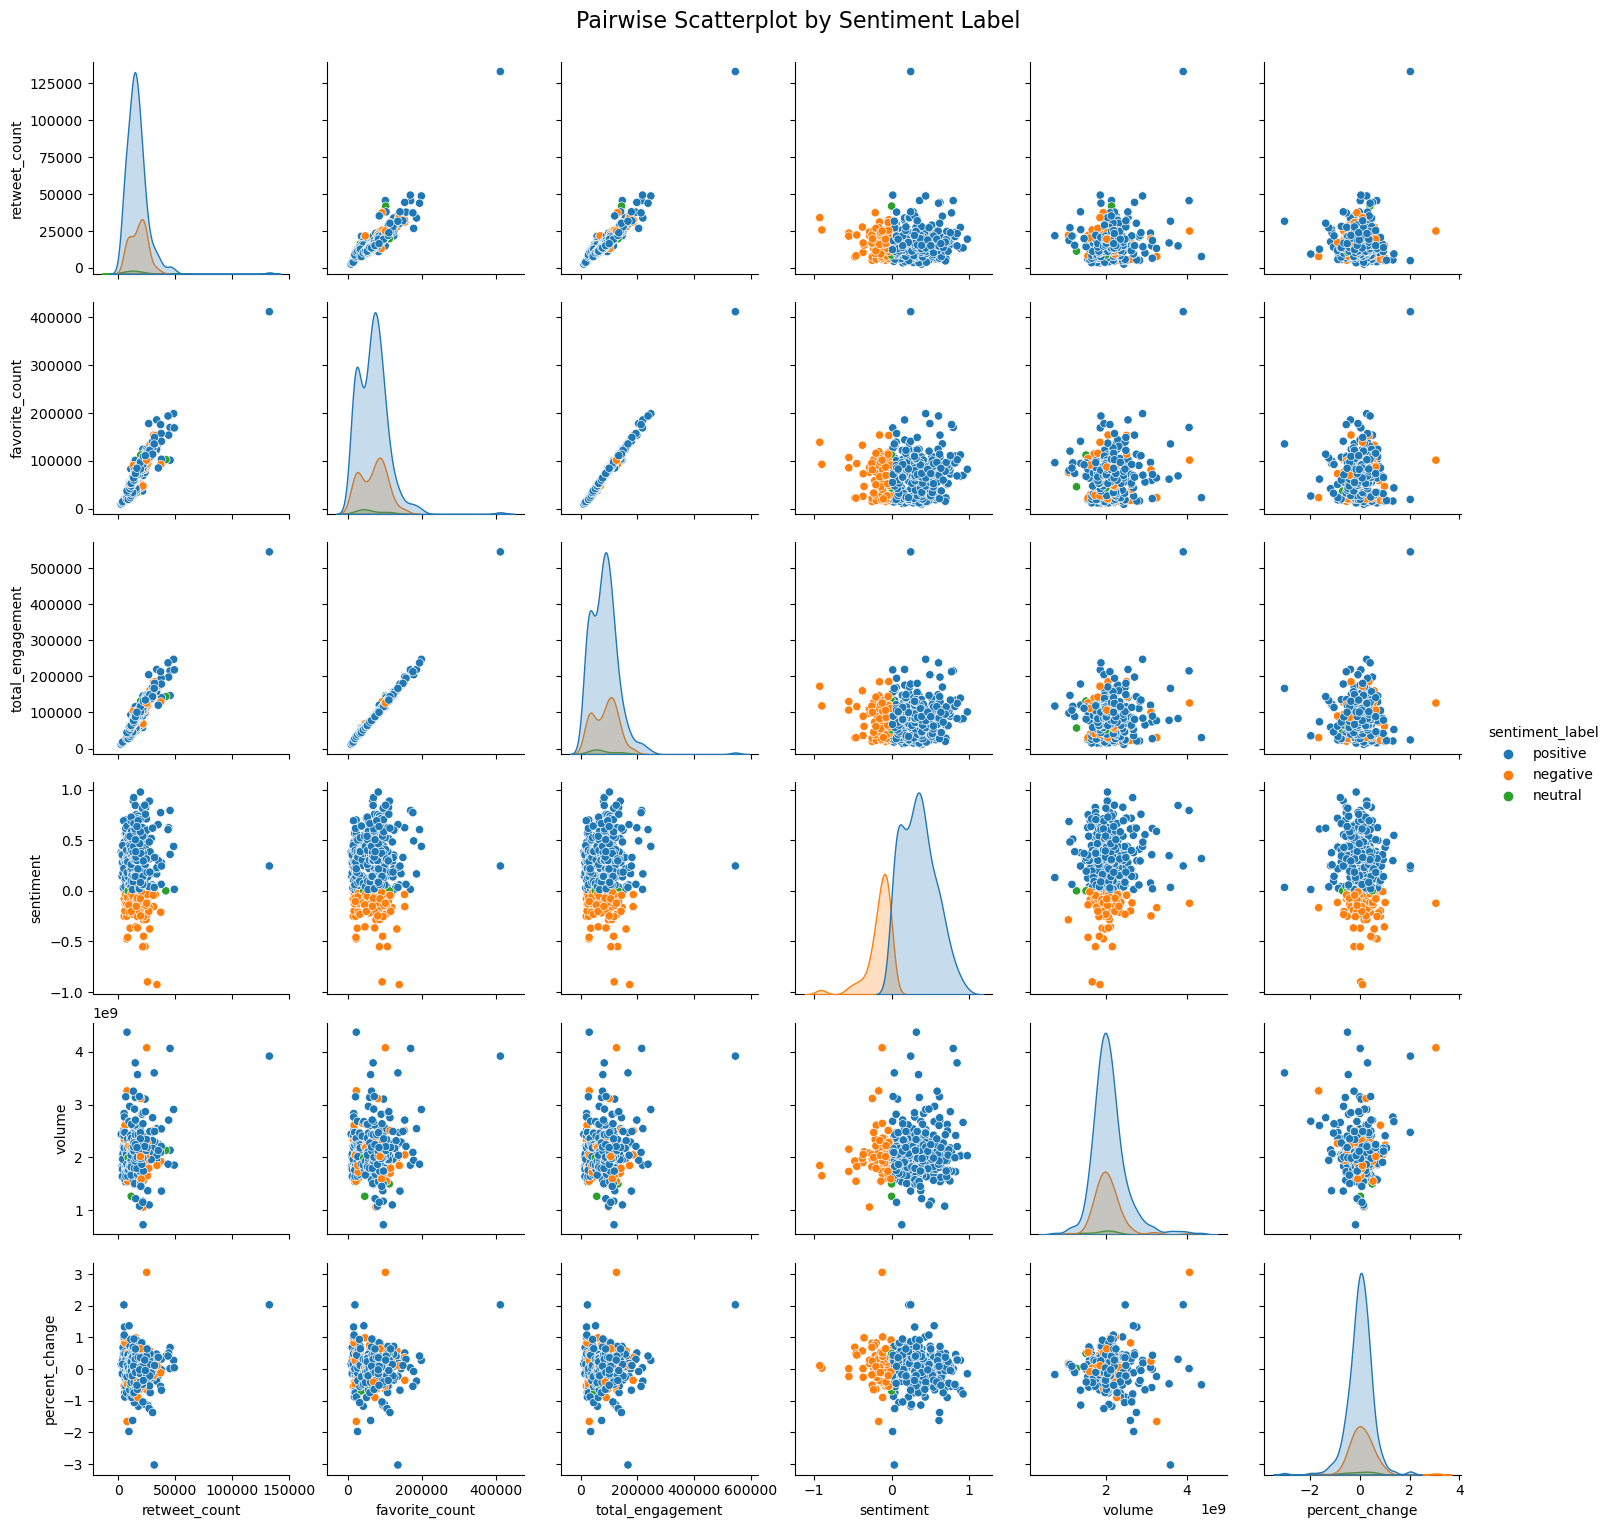

In [1300]:
# Pairwise scatter plot matrix with colored points based on sentiment labels
sns.pairplot(df2, hue='sentiment_label');
plt.suptitle('Pairwise Scatterplot by Sentiment Label', y=1.02, fontsize=16);

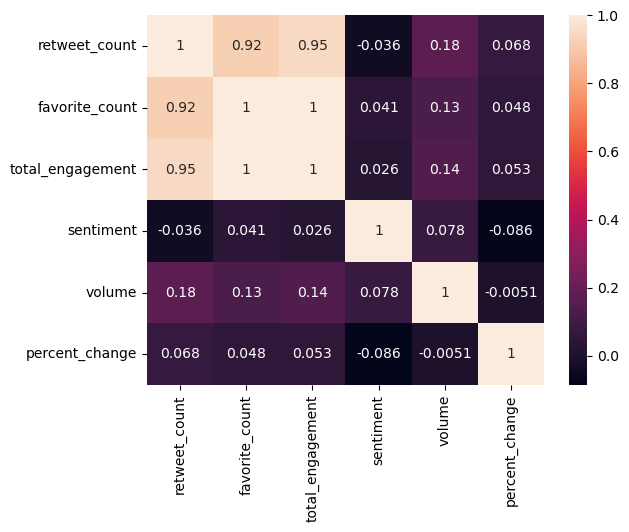

In [1301]:
df2_corr = df2.corr()
sns.heatmap(df2_corr, annot=True);

### Feature Questions <a class="anchor" id="Feature-Questions"></a>
#### How do Day to Day (DTD) S&P 500 trends change depending on tweet sentiment? <a class="anchor" id="DTD"></a>

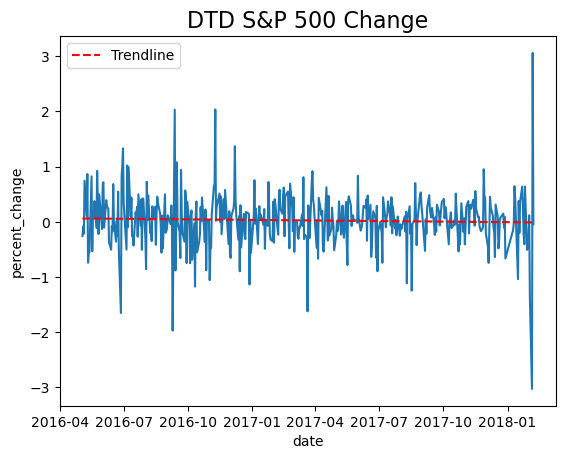

In [1302]:
# Create the line plot
sns.lineplot(x=df2.index, y='percent_change', data=df2)

# Calculate and plot the overall trend line
trend = plt.np.polyfit(df2.index.astype(int), df2['percent_change'], 1)
plt.plot(df2.index, trend[0] * df2.index.astype(int) + trend[1], color='red', linestyle='--', label='Trendline')

# Add title
plt.title('DTD S&P 500 Change', fontsize=16)
plt.legend()
plt.show()

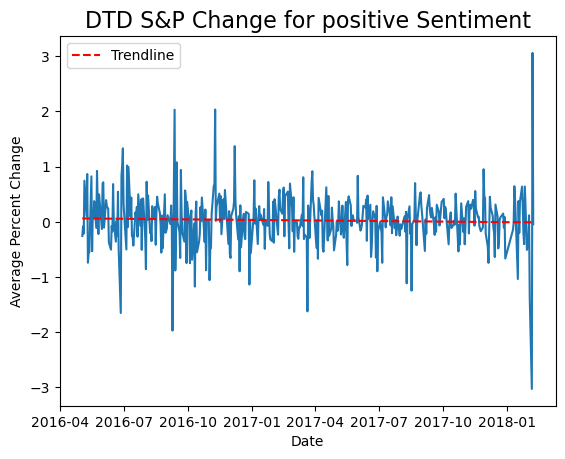

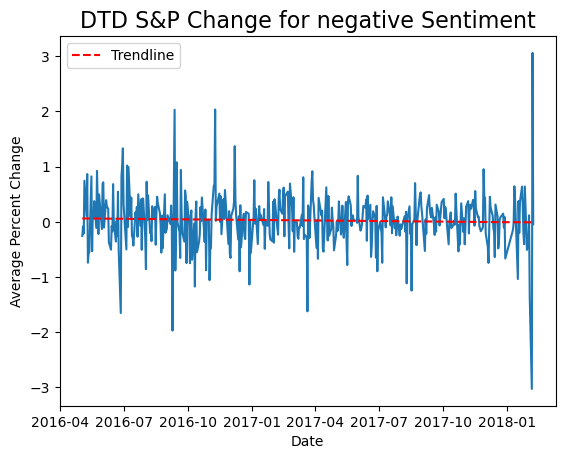

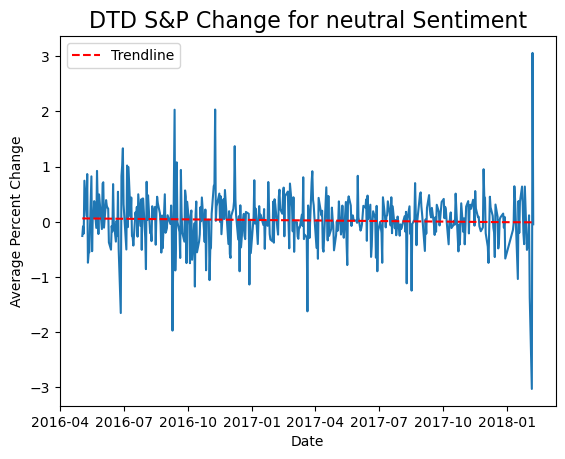

In [1303]:
# Create a list of sentiment labels
sentiment_labels = df2['sentiment_label'].unique()


# Create separate line plots for each sentiment label
for elem in sentiment_labels:
    df_sentiment = df2.loc[df2.sentiment_label == elem,:]
    
    plt.figure()
    ax = sns.lineplot(x=df2.index, y='percent_change', data=df2)
    
    # Calculate the linear regression line using scipy.stats.linregress
    x = np.arange(len(df2))
    y = df2['percent_change']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Plot the trendline
    plt.plot(df2.index, slope * x + intercept, color='red', linestyle='--', label='Trendline')
    
    plt.title(f'DTD S&P Change for {elem} Sentiment', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Average Percent Change')
    plt.legend()
    
    plt.show()

#### How do Month to Month (MTM) S&P 500 trends change depending on tweet sentiment? <a class="anchor" id="MTM"></a>

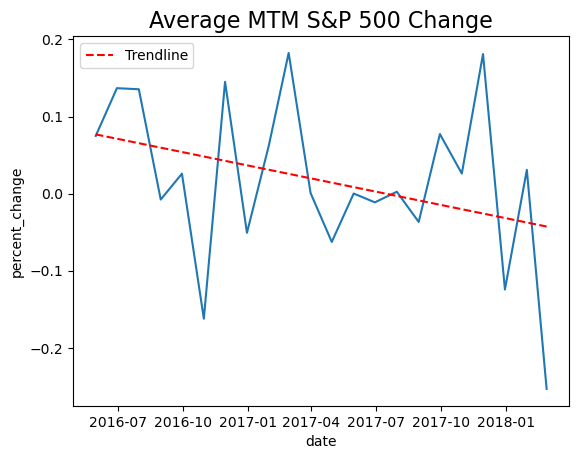

In [1304]:
# Resample data on a monthly basis and calculate the mean percent change
df_monthly = df2.resample('M').mean()

# Create the line plot
sns.lineplot(x=df_monthly.index, y='percent_change', data=df_monthly)

# Calculate and plot the overall trend line
trend = plt.np.polyfit(df_monthly.index.astype(int), df_monthly['percent_change'], 1)
plt.plot(df_monthly.index, trend[0] * df_monthly.index.astype(int) + trend[1], color='red', linestyle='--', label='Trendline')

# Add title
plt.title('Average MTM S&P 500 Change', fontsize=16)
plt.legend()
plt.show()


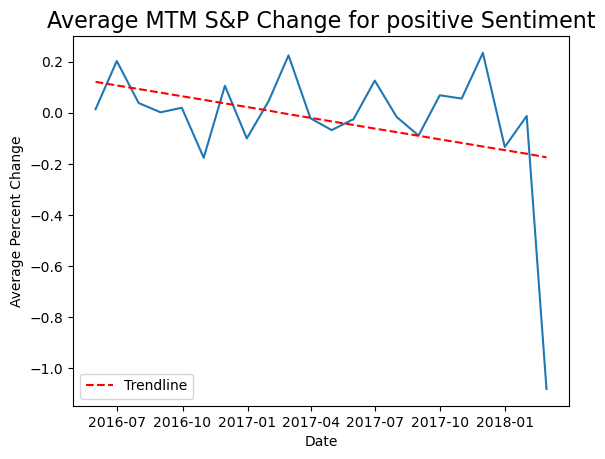

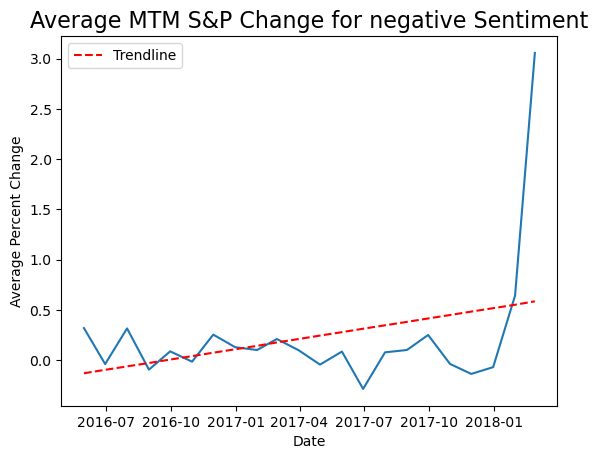

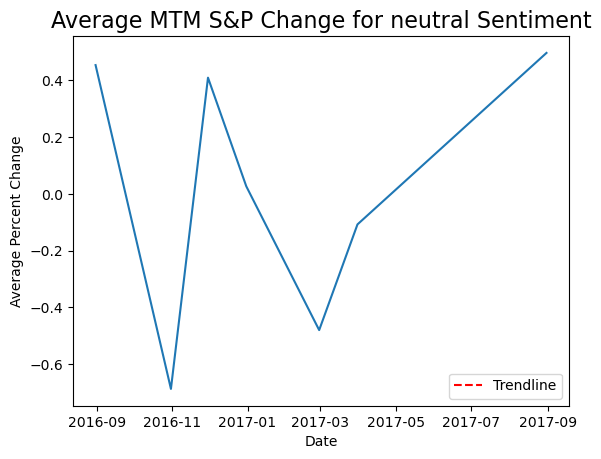

In [1305]:
# Create a list of sentiment labels
sentiment_labels = df2['sentiment_label'].unique()


# Create separate line plots for each sentiment label
for elem in sentiment_labels:
    df_sentiment = df2.loc[df2.sentiment_label == elem,:]
    df_monthly = df_sentiment.resample('M').mean()
    
    plt.figure()
    ax = sns.lineplot(x=df_monthly.index, y='percent_change', data=df_monthly)
    
    # Calculate the linear regression line using scipy.stats.linregress
    x = np.arange(len(df_monthly))
    y = df_monthly['percent_change']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Plot the trendline
    plt.plot(df_monthly.index, slope * x + intercept, color='red', linestyle='--', label='Trendline')
    
    plt.title(f'Average MTM S&P Change for {elem} Sentiment', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Average Percent Change')
    plt.legend()
    
    plt.show()


A big dip in S&P 500 stocks can be seen in the positive sentiment graph for February of 2018. This can be explained by The Federal Reserve signaling its intention to raise interest rates to prevent potential inflation, and over market overevaluation. This was marked by <a href="https://money.cnn.com/2018/02/05/investing/stock-market-today-dow-jones/index.html">CNN</a> as "...the biggest decline since August 2011, during the European debt crisis" An uptick can be seen the following day when Presiden't Trump's tweets were more negative which is explained by stocks commonly bouncing back after a large drop. Perhaps more representative information can be expressed through these visualizations with the removal of outliers.

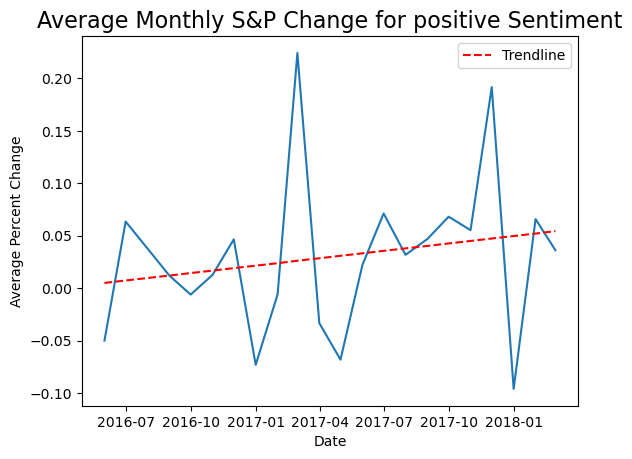

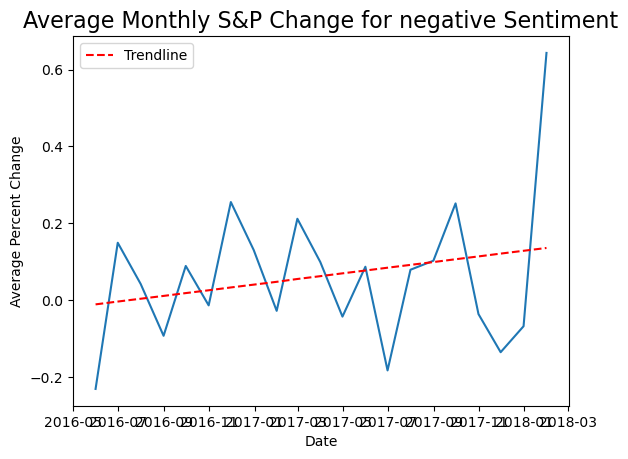

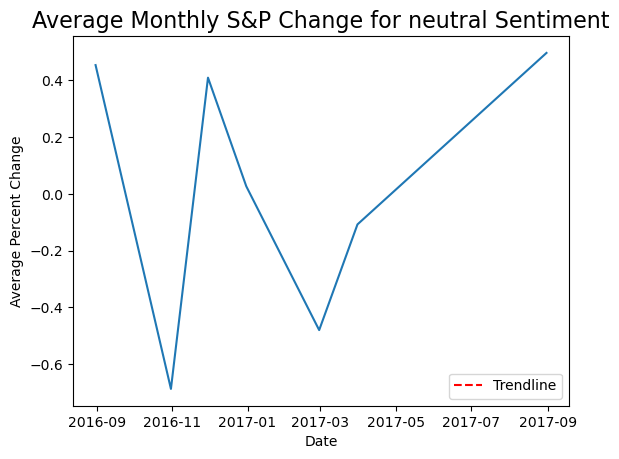

In [1306]:
# remove outliers
min_threshold = df2.percent_change.quantile(0.05)  # 5th percentile
max_threshold = df2.percent_change.quantile(0.95)  # 95th percentile


# Filter data using thresholds
df3 = df2.loc[(df2['percent_change'] >= min_threshold) & (df2['percent_change'] <= max_threshold)]


# Create a list of sentiment labels
sentiment_labels = df3['sentiment_label'].unique()


# Create separate line plots for each sentiment label
for elem in sentiment_labels:
    df_sentiment = df3.loc[df3.sentiment_label == elem,:]
    df_monthly = df_sentiment.resample('M').mean()
    
    plt.figure()
    ax = sns.lineplot(x=df_monthly.index, y='percent_change', data=df_monthly)
    
    # Calculate the linear regression line using scipy.stats.linregress
    x = np.arange(len(df_monthly))
    y = df_monthly['percent_change']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Plot the trendline
    plt.plot(df_monthly.index, slope * x + intercept, color='red', linestyle='--', label='Trendline')
    
    plt.title(f'Average Monthly S&P Change for {elem} Sentiment', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Average Percent Change')
    plt.legend()
    
    plt.show()

After removing outliers we can see that the general trend of the graphs are less steep than the previous interation. The graph displaying positive sentiment tweets even changes from showing a negative trend, to a positive trend.

#### Which stocks, and their correspoding `percent_change`, have the highest correlation with Trump's tweet sentiment? <a class="anchor" id="Ten"></a>

In [1307]:
# Utilizing the previously established Dataframe which includes each individual in the S&P 500
names = df.Name.unique()
correlations = {}

for elem in names:
    temp_df = df.query('Name == @elem')
    corr = temp_df['percent_change'].corr(temp_df['sentiment'])
    correlations[elem] = corr

# Sort the correlations dictionary in descending order and take the top 3 positive correlations
top_correlations_pos = dict(sorted(correlations.items(), key=lambda item: item[1], reverse=True)[:3])

# Sort the correlations dictionary in ascending order and take the top 3 negative correlations
top_correlations_neg = dict(sorted(correlations.items(), key=lambda item: item[1], reverse=False)[:3])

print('Stocks with the highest correlations:')
display(top_correlations_pos)
display(top_correlations_neg)

Stocks with the highest correlations:


{'M': 0.08762586189111994,
 'JWN': 0.07664974040908576,
 'AIG': 0.07297852286374615}

{'NWL': -0.15727141174043446,
 'DWDP': -0.15135302080999352,
 'AAPL': -0.14987347433539971}

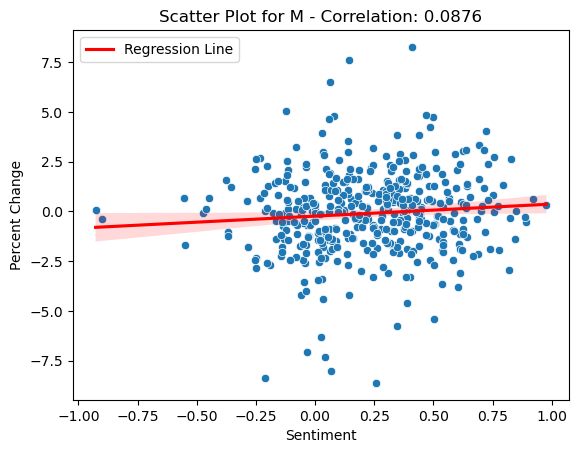

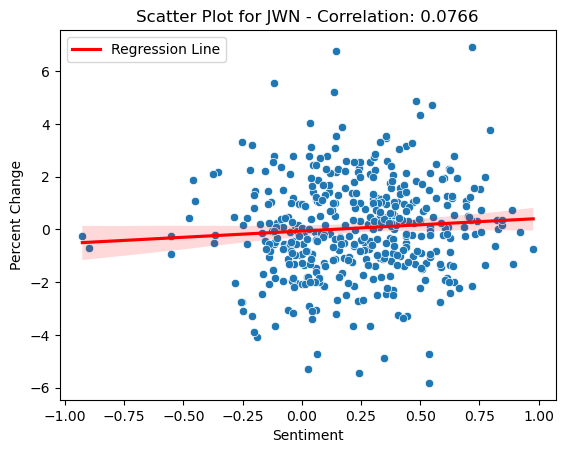

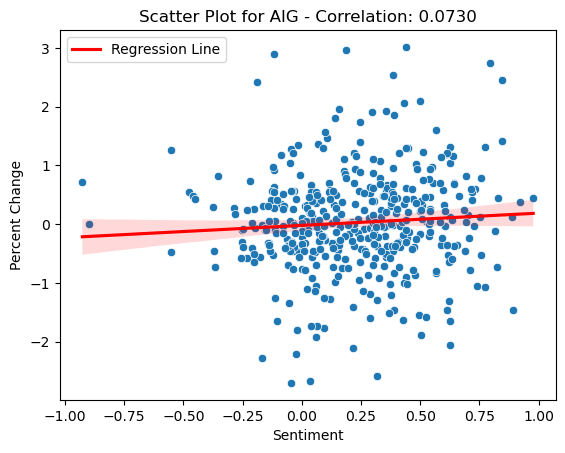

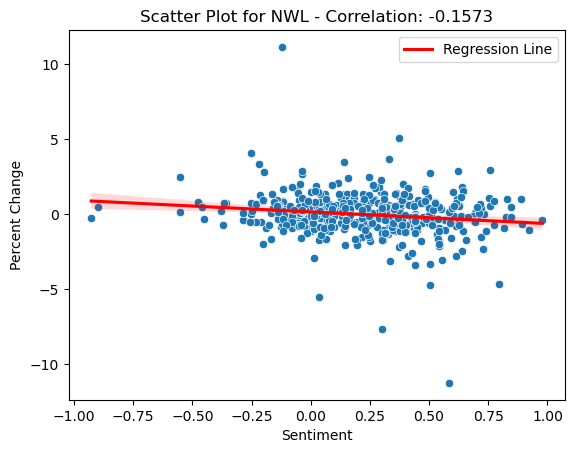

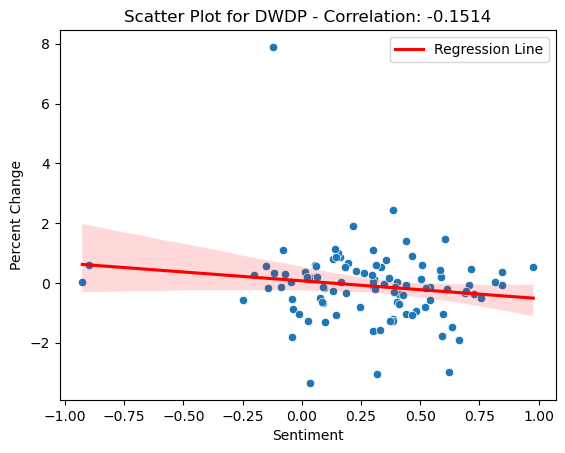

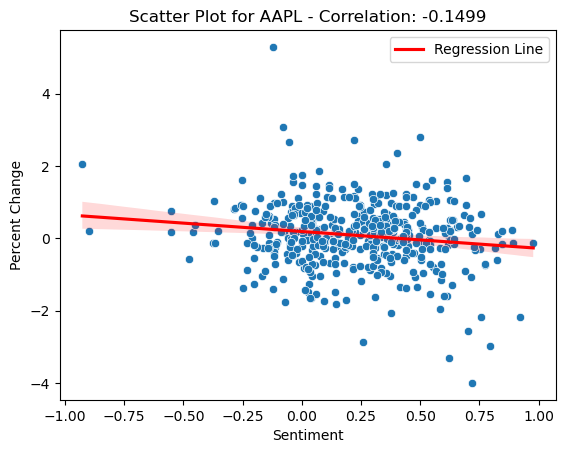

In [1308]:
lst = list(top_correlations_pos.keys()) + list(top_correlations_neg.keys())

for elem in lst:
    subset_df = df.query('Name == @elem')
    ax = sns.scatterplot(x=subset_df.sentiment, y = subset_df.percent_change, data=df, )
    sns.regplot(x=subset_df.sentiment, y=subset_df.percent_change, data=subset_df, scatter=False, color='red', label='Regression Line')
    plt.title(f'Scatter Plot for {elem} - Correlation: {correlations[elem]:.4f}')
    plt.xlabel('Sentiment')
    plt.ylabel('Percent Change')
    plt.legend()
    plt.show()

## Regression Modeling <a class="anchor" id="Regression-Modeling"></a>

In [1410]:
features = ['retweet_count','favorite_count','total_engagement','sentiment','volume']
X = pd.DataFrame(df3[features])
y = df3['percent_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Linear Regeression for Average S&P 500 Percentage of Change

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.08626
Feature: 4, Score: -0.00000

Feature 0 = retweet_count
Feature 1 = favorite_count
Feature 2 = total_engagement
Feature 3 = sentiment
Feature 4 = volume


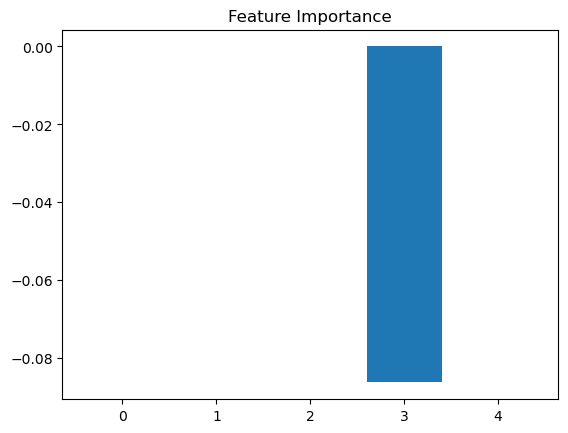

In [1411]:
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Get importance
importance = lr.coef_

# Summarize feature importance
for i, elem in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, elem))  # Increase the number of decimal places
print('')
for elem in range(len(X.columns)):
    print('Feature ' + str(elem) + ' = ' + X.columns[elem])

# Plot the feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.show()



Feature importance measures how much each feature contributes to the predictions made by a machine learning model. In our investigation, feature three (`sentiment`) has the largest influence on the predictions of our model since it is the feature closest to 1 or -1. A coefficient close to zero generally suggests that the corresponding feature has little impact on the target variable.

#### Model Evaluation

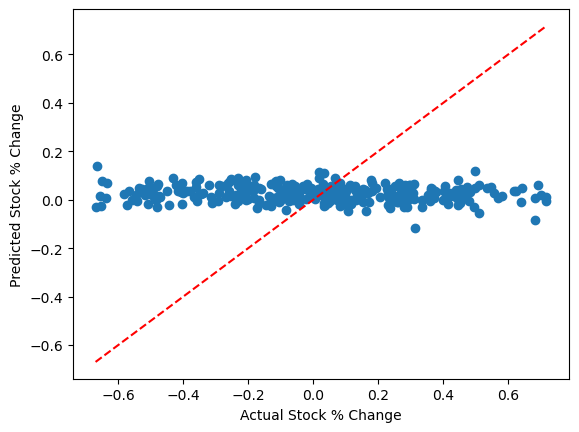

R² Score: -0.0366


In [1313]:
y_train_pred = cross_val_predict(lr, X_train, y_train, cv = 10)
plt.scatter(x=y_train, y = y_train_pred)
plt.xlabel('Actual Stock % Change')
plt.ylabel('Predicted Stock % Change')

# Diagonal reference line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')

plt.show()

print('R² Score: {:.4f}'.format(r2_score(y_train, y_train_pred)))

The graph displays the actual stock `percent_change` plotted against the predicted stock `percent_change`. The red reference line is the line of best fit which represents the ideal scenario where predicted values match the actual values perfectly. R² is a measure of how well the model fits the data compared to a simple mean model. A negative R² value means that the model's predictions are worse than using average S&P 500 `percent_change` for every prediciton; also known as the "empty" or "dummy" model.

#### Test Predicitons

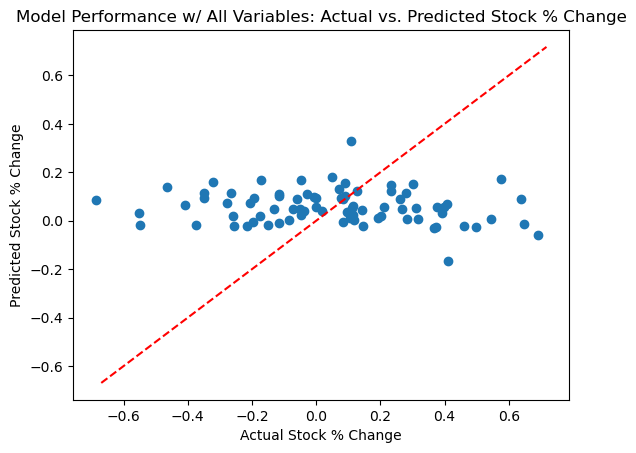

R² Score: -0.1347


In [1315]:
y_test_pred = cross_val_predict(lr, X_test, y_test, cv = 10)
plt.scatter(x=y_test, y = y_test_pred)
plt.xlabel('Actual Stock % Change')
plt.ylabel('Predicted Stock % Change')

# Diagonal reference line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.title('Model Performance w/ All Variables: Actual vs. Predicted Stock % Change')
plt.show()

print('R² Score: {:.4f}'.format(r2_score(y_test, y_test_pred)))

The plot and R² value for the test dataset still performs worse than if we were to use the empty model for every prediciton.

Features: total_engagement, sentiment - R²: 0.0006
Features: favorite_count, sentiment - R²: 0.0005
Features: total_engagement, sentiment, volume - R²: 0.0002


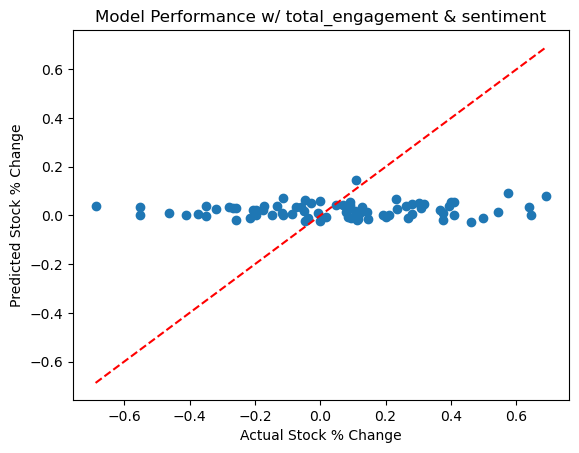

In [1365]:
# Create an empty dictionary to store the R² values for each feature combination
r2_values = {}

# Iterate through different numbers of features (from 1 to the total number of features)
for num_features in range(1, len(features) + 1):
    # Generate all combinations of features for the current number
    feature_combinations = combinations(features, num_features)
    
    # Iterate through each feature combination
    for combination in feature_combinations:
        selected_features = list(combination)
        X = pd.DataFrame(df3[selected_features])
        y = df3['percent_change']
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        
        # fit the linear regression model
        lr.fit(X_train, y_train)
        
        # Predict using the test set
        y_test_pred = lr.predict(X_test)
        
        # Calculate the R² value and store it in the dictionary
        r2 = r2_score(y_test, y_test_pred)
        r2_values[tuple(selected_features)] = r2

# Find the top three combinations with the highest R² values
top_combinations = sorted(r2_values.items(), key=lambda x: x[1], reverse=True)[:3]

# Print the best three combinations and their R² values
for combination, r2 in top_combinations:
    print(f"Features: {', '.join(combination)} - R²: {r2:.4f}")

    
best_combination = max(r2_values, key=r2_values.get)

X = pd.DataFrame(df3[list(best_combination)])
y = df3['percent_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
best = lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

# Create the scatter plot
plt.scatter(x=y_test, y=y_test_pred)
plt.xlabel('Actual Stock % Change')
plt.ylabel('Predicted Stock % Change')
plt.title('Model Performance w/ total_engagement & sentiment')
# Diagonal reference line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()


After going through every combination of features to predict our target variable, our best models still do marginally better than using the empty model

#### Univariate P-values of the variables for the best model

In [1398]:
# Model Statistics

features = ['total_engagement','sentiment']
X = pd.DataFrame(df3[features])
y = df3['percent_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


p_values = f_regression(X,y)[1].round(3)

reg_summary = pd.DataFrame(data = X.columns.values, columns=['Features'])
reg_summary ['Coefficients'] = lr.coef_.round(3)
reg_summary ['P-values'] = p_values.round(3)
reg_summary

,Features,Coefficients,P-values
0,total_engagement,0.000,0.464
1,sentiment,-0.092,0.103


The coefficients and p-values for our best model indicate that while `total_engagement` had minimal impact (0.000 coefficient, p-value of 0.464), `sentiment` demonstrated a slightly negative influence (-0.092 coefficient, p-value of 0.103). This negative influence means that as `sentiment` increases, the average percent change of S&P 500 stocks decrease. The P-value indicates that there is no strong evidence to support a significant relationship between `total engagement`, `sentiment`, and `percent_change` 

### Linear Regression for Strongest Correlate S&P 500 Stocks

In [1413]:
# Previously initialized list of stocks with strongest correlations
best_stock_df = df[df['Name'].isin(lst)]

features = ['retweet_count','favorite_count','total_engagement','sentiment','volume']
X = pd.DataFrame(best_stock_df[features])
y = best_stock_df['percent_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Feature: 0, Score: -0.00001
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.03128
Feature: 4, Score: -0.00000

Feature 0 = retweet_count
Feature 1 = favorite_count
Feature 2 = total_engagement
Feature 3 = sentiment
Feature 4 = volume


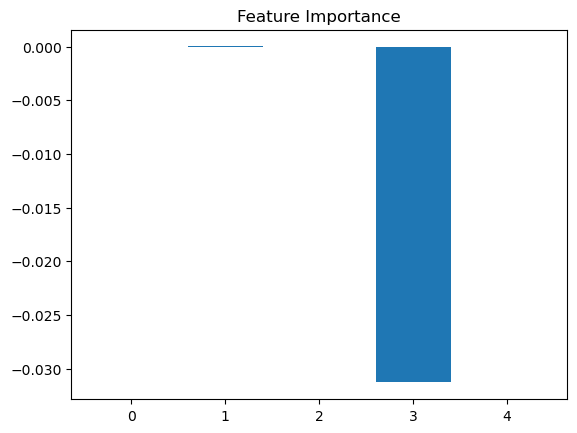

In [1414]:
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Get importance
importance = lr.coef_

# Summarize feature importance
for i, elem in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, elem))  # Increase the number of decimal places

print('')
for elem in range(len(X.columns)):
    print('Feature ' + str(elem) + ' = ' + X.columns[elem])

# Plot the feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.show()

In this investigation, feature three (`sentiment`) once again has the largest influence on the predictions of our model since it is the feature closest to 1 or -1.

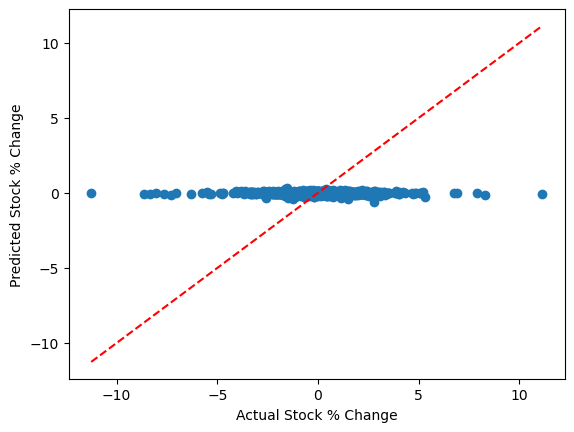

R² Score: -0.0057


In [1415]:
y_train_pred = cross_val_predict(lr, X_train, y_train, cv = 10)
plt.scatter(x=y_train, y = y_train_pred)
plt.xlabel('Actual Stock % Change')
plt.ylabel('Predicted Stock % Change')

# Diagonal reference line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')

plt.show()

print('R² Score: {:.4f}'.format(r2_score(y_train, y_train_pred)))

This model's negative R² value means that the model's predictions are worse than using average S&P 500 `percent_change` for every prediciton; also known as the "empty" or "dummy" model.

#### Test Predicitons

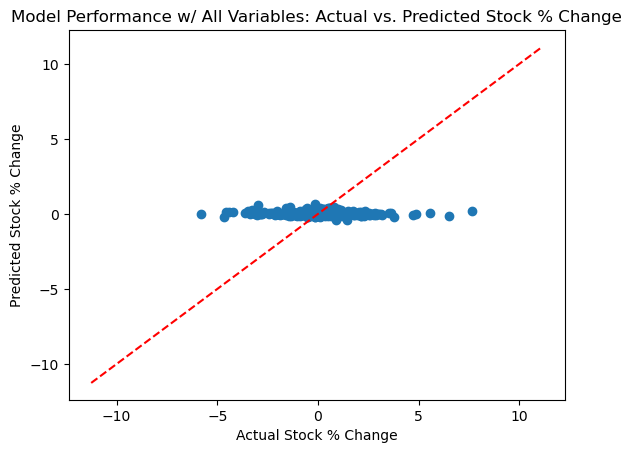

R² Score: -0.0244


In [1416]:
y_test_pred = cross_val_predict(lr, X_test, y_test, cv = 10)
plt.scatter(x=y_test, y = y_test_pred)
plt.xlabel('Actual Stock % Change')
plt.ylabel('Predicted Stock % Change')

# Diagonal reference line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.title('Model Performance w/ All Variables: Actual vs. Predicted Stock % Change')
plt.show()

print('R² Score: {:.4f}'.format(r2_score(y_test, y_test_pred)))

The plot and R² value for the test dataset still performs worse than if we were to use the empty model for every prediciton; it even performs worse than our last linear regression model with the average of all S&P 500 stocks

Features: sentiment - R²: -0.0009
Features: retweet_count, sentiment - R²: -0.0019
Features: retweet_count, favorite_count, sentiment - R²: -0.0020


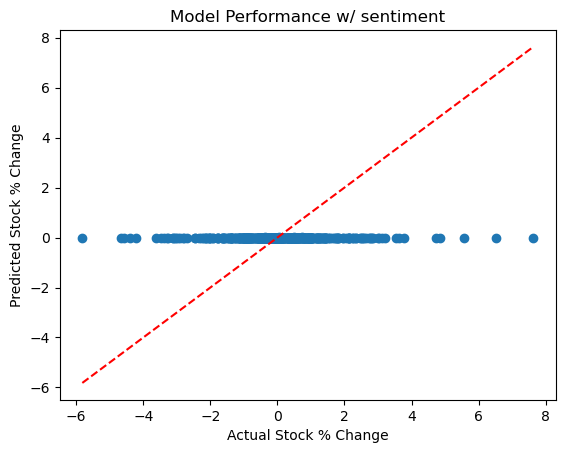

In [1419]:
# Create an empty dictionary to store the R² values for each feature combination
r2_values = {}

# Iterate through different numbers of features (from 1 to the total number of features)
for num_features in range(1, len(features) + 1):
    # Generate all combinations of features for the current number
    feature_combinations = combinations(features, num_features)
    
    # Iterate through each feature combination
    for combination in feature_combinations:
        selected_features = list(combination)
        X = pd.DataFrame(best_stock_df[selected_features])
        y = best_stock_df['percent_change']
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        
        # fit the linear regression model
        lr.fit(X_train, y_train)
        
        # Predict using the test set
        y_test_pred = lr.predict(X_test)
        
        # Calculate the R² value and store it in the dictionary
        r2 = r2_score(y_test, y_test_pred)
        r2_values[tuple(selected_features)] = r2

# Find the top three combinations with the highest R² values
top_combinations = sorted(r2_values.items(), key=lambda x: x[1], reverse=True)[:3]

# Print the best three combinations and their R² values
for combination, r2 in top_combinations:
    print(f"Features: {', '.join(combination)} - R²: {r2:.4f}")

    
best_combination = max(r2_values, key=r2_values.get)

X = pd.DataFrame(best_stock_df[list(best_combination)])
y = best_stock_df['percent_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
best = lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

# Create the scatter plot
plt.scatter(x=y_test, y=y_test_pred)
plt.xlabel('Actual Stock % Change')
plt.ylabel('Predicted Stock % Change')
plt.title('Model Performance w/ sentiment')
# Diagonal reference line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()


After going through every combination of features to predict our target variable, our best models still do worse than using the empty model

#### Univariate P-values of the variables for the best model

In [1420]:
features = ['sentiment']
X = pd.DataFrame(best_stock_df[features])
y = best_stock_df['percent_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


p_values = f_regression(X,y)[1].round(3)

reg_summary = pd.DataFrame(data = X.columns.values, columns=['Features'])
reg_summary ['Coefficients'] = lr.coef_.round(3)
reg_summary ['P-values'] = p_values.round(3)
reg_summary

,Features,Coefficients,P-values
0,sentiment,-0.011,0.818


The coefficients and p-value for our best model indicates that `sentiment` demonstrated a slightly negative influence (-0.011 coefficient, p-value of 0.818). This negative influence means that as `sentiment` increases, the average percent change of S&P 500 stocks decrease. The P-value indicates that there is no strong evidence to support a significant relationship between `sentiment` and `percent_change` of S&P 500 stocks. Nonetheless, this model vastly underperformed at predicting the average `percent_change` for six of our strongest correlate S&P 500 stocks.

## Conclusion <a class="anchor" id="Conclusion"></a>
The linear regression model applied to predict the average S&P 500 percent change didn't perform as well as expected, indicating that the selected features might not have strong predictive power. Moving forward, the next steps involve exploring binary classification modeling to determine which variables are more effective in predicting whether S&P 500 stocks will experience a positive or negative increase. By shifting the focus to classification, we can better understand the underlying patterns and potentially identify key features that drive such directional changes.